# DVS Benchmark

In [62]:
import asyncio
import time
from typing import List, Text

import httpx
import random
import uuid
from faker import Faker
from pydantic import BaseModel, Field
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from pathlib import Path
import dvs.utils.to as TO
from scipy.signal import savgol_filter
from dvs.config import console, settings
from dvs.types.search_request import EncodingType, SearchRequest

## Definitions

In [63]:
# Constants
QUERY_COUNT = 1000
BASE_URL = "http://localhost:8000"
TARGET_BENCHMARK_FILE = Path("data/benchmark_results.csv").resolve()
TARGET_BENCHMARK_FILE.parent.mkdir(parents=True, exist_ok=True)

In [64]:
# Initialization
fake = Faker()
openai_client = settings.openai_client
cache = settings.cache

In [65]:
# Models
class RequestRecord(BaseModel):
    timestamp: float = Field(default_factory=lambda: time.time())
    http_method: Text = Field(...)
    endpoint: Text = Field(...)
    status_code: int = Field(default=500)
    response_time_ms: int = Field(default=0)
    payload_size_bytes: int = Field(default=0)
    server_timing: Text = Field(default="")


class TestScenario(BaseModel):
    concurrent_users: int


class BenchmarkSchema(BaseModel):
    test_id: Text
    scenario: TestScenario
    request_records: List[RequestRecord]
    results_summary: Text

In [66]:
# Utilities
async def record_search(
    req: SearchRequest, *, semaphore: "asyncio.Semaphore"
) -> "RequestRecord":
    async with semaphore:
        req_record = RequestRecord(http_method="POST", endpoint="/search")
        async with httpx.AsyncClient(base_url=BASE_URL) as client:
            resp = await client.post("/search", json=req.model_dump(exclude_none=True))
            req_record.status_code = resp.status_code
            req_record.response_time_ms = int(resp.elapsed.total_seconds() * 1000)
            req_record.payload_size_bytes = len(resp.content)
            req_record.server_timing = resp.headers.get("Server-Timing", "") or ""
        return req_record


async def run_benchmark(
    base64_vectors: List[Text], *, workers: int, top_k: int, warmup: bool = False
) -> BenchmarkSchema:
    benchmark = BenchmarkSchema(
        test_id=str(uuid.uuid4()),
        scenario=TestScenario(concurrent_users=workers),
        request_records=[],
        results_summary="",
    )
    semaphore = asyncio.Semaphore(workers)

    # Create tasks
    tasks: List[asyncio.Task] = []
    for base64_vec in base64_vectors:
        if warmup:  # 1% warmup
            if random.random() > 0.01:
                continue
        _task = asyncio.create_task(
            record_search(
                SearchRequest(
                    query=base64_vec, top_k=top_k, encoding=EncodingType.BASE64
                ),
                semaphore=semaphore,
            )
        )
        tasks.append(_task)
    # Run tasks
    for future in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
        result = await future
        benchmark.request_records.append(result)

    # Sort by timestamp
    benchmark.request_records.sort(key=lambda x: x.timestamp)
    return benchmark


async def _prepare_base64_vectors(queries: List[Text]) -> List[Text]:
    vectors = await TO.queries_to_vectors_with_cache(
        queries,
        cache=cache,
        openai_client=openai_client,
        model=settings.EMBEDDING_MODEL,
        dimensions=settings.EMBEDDING_DIMENSIONS,
    )
    base64_vectors = [TO.vector_to_base64(vec) for vec in vectors]
    return base64_vectors

## Prepare queries

In [67]:
console.print(f"Preparing {QUERY_COUNT} queries...")
base64_vectors = await _prepare_base64_vectors(
    [fake.sentence() for _ in range(QUERY_COUNT)]
)
console.print(f"Prepared {len(base64_vectors)} queries.")

Preparing 1000 queries...

Prepared 1000 queries.

## Run benchmark - Concurrent Clients


In [68]:
## Global settings
TOP_K = 20

In [69]:
# Warmup
console.print("Running warmup...")
benchmark_warmup = await run_benchmark(
    base64_vectors, workers=1, top_k=TOP_K, warmup=True
)

# Concurrent 1
console.print("Running benchmark with 1 concurrent client...")
benchmark_concurrent_1 = await run_benchmark(base64_vectors, workers=1, top_k=TOP_K)

# Concurrent 2
console.print("Running benchmark with 2 concurrent clients...")
benchmark_concurrent_2 = await run_benchmark(base64_vectors, workers=2, top_k=TOP_K)

# Concurrent 5
console.print("Running benchmark with 5 concurrent clients...")
benchmark_concurrent_5 = await run_benchmark(base64_vectors, workers=5, top_k=TOP_K)

# Concurrent 10
console.print("Running benchmark with 10 concurrent clients...")
benchmark_concurrent_10 = await run_benchmark(base64_vectors, workers=10, top_k=TOP_K)

# Concurrent 20
console.print("Running benchmark with 20 concurrent clients...")
benchmark_concurrent_20 = await run_benchmark(base64_vectors, workers=20, top_k=TOP_K)

Running warmup...

100%|██████████| 988/988 [00:25<00:00, 38.53it/s]


Running benchmark with 1 concurrent client...

100%|██████████| 1000/1000 [00:26<00:00, 37.85it/s]


Running benchmark with 2 concurrent clients...

100%|██████████| 1000/1000 [00:15<00:00, 62.84it/s]


Running benchmark with 5 concurrent clients...

100%|██████████| 1000/1000 [00:10<00:00, 94.27it/s]


Running benchmark with 10 concurrent clients...

100%|██████████| 1000/1000 [00:09<00:00, 104.00it/s]


Running benchmark with 20 concurrent clients...

100%|██████████| 1000/1000 [00:09<00:00, 107.49it/s]


In [70]:
# Load the benchmark results
df_concurrent_1 = pd.DataFrame(
    [rec.model_dump() for rec in benchmark_concurrent_1.request_records]
)
df_concurrent_2 = pd.DataFrame(
    [rec.model_dump() for rec in benchmark_concurrent_2.request_records]
)
df_concurrent_5 = pd.DataFrame(
    [rec.model_dump() for rec in benchmark_concurrent_5.request_records]
)
df_concurrent_10 = pd.DataFrame(
    [rec.model_dump() for rec in benchmark_concurrent_10.request_records]
)
df_concurrent_20 = pd.DataFrame(
    [rec.model_dump() for rec in benchmark_concurrent_20.request_records]
)

In [71]:
# Summary Tables
summary_data = {
    "Concurrent Level": [],
    "Mean Response Time (ms)": [],
    "Std Dev Response Time (ms)": [],
    "Max Response Time (ms)": [],
    "Min Response Time (ms)": [],
    "Median Response Time (ms)": [],
    "90th Percentile (ms)": [],
    "Error Rate (%)": [],
}

# Assuming df_concurrent_1, df_concurrent_2, etc. are your dataframes
concurrent_dfs = {
    "1 Concurrent": df_concurrent_1,
    "2 Concurrent": df_concurrent_2,
    "5 Concurrent": df_concurrent_5,
    "10 Concurrent": df_concurrent_10,
    "20 Concurrent": df_concurrent_20,
}

for label, df in concurrent_dfs.items():
    summary_data["Concurrent Level"].append(label)
    summary_data["Mean Response Time (ms)"].append(df["response_time_ms"].mean())
    summary_data["Std Dev Response Time (ms)"].append(df["response_time_ms"].std())
    summary_data["Max Response Time (ms)"].append(df["response_time_ms"].max())
    summary_data["Min Response Time (ms)"].append(df["response_time_ms"].min())
    summary_data["Median Response Time (ms)"].append(df["response_time_ms"].median())
    summary_data["90th Percentile (ms)"].append(df["response_time_ms"].quantile(0.9))
    error_rate = (df["status_code"] != 200).mean() * 100
    summary_data["Error Rate (%)"].append(error_rate)

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Concurrent Level,Mean Response Time (ms),Std Dev Response Time (ms),Max Response Time (ms),Min Response Time (ms),Median Response Time (ms),90th Percentile (ms),Error Rate (%)
0,1 Concurrent,19.594,5.581605,73,14,18.0,24.0,0.0
1,2 Concurrent,24.822,7.794040,88,11,23.0,33.0,0.0
2,5 Concurrent,39.225,16.113784,185,12,37.0,52.0,0.0
3,10 Concurrent,70.079,21.681302,171,22,69.0,94.0,0.0
4,20 Concurrent,139.270,39.735652,269,49,140.5,188.0,0.0


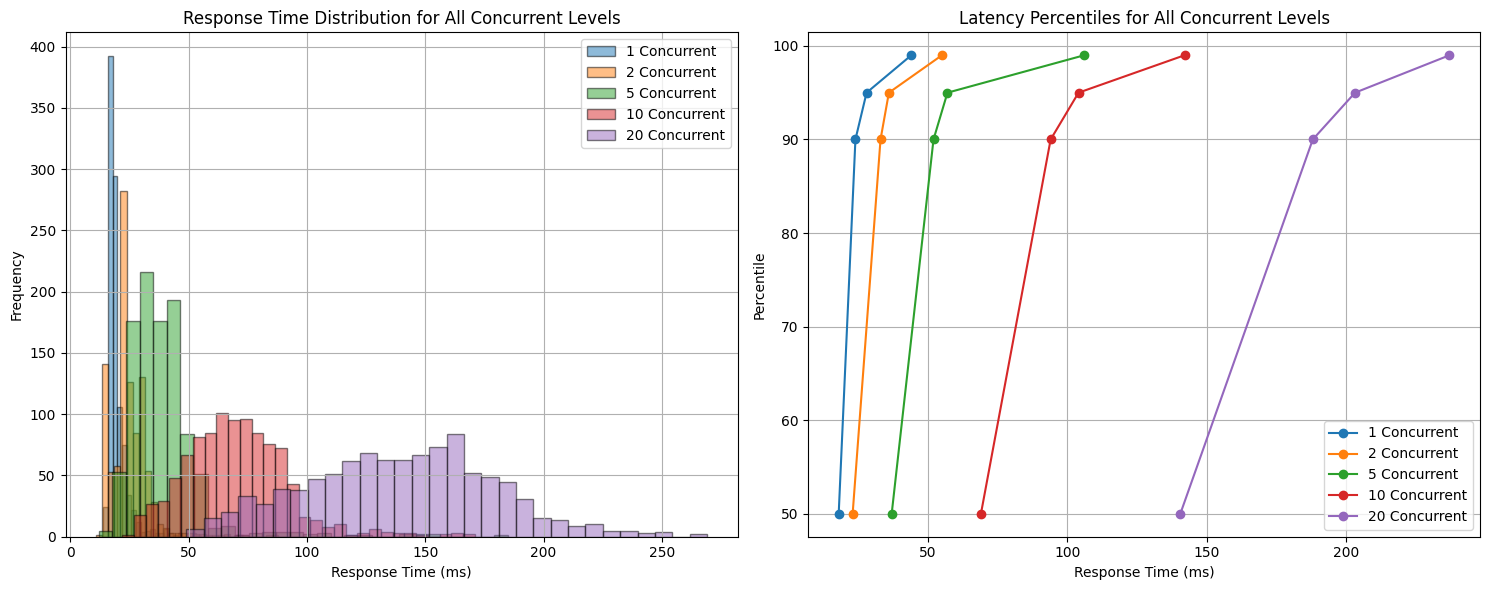

In [72]:
# Calculate percentiles and plot response time distribution for all concurrent levels
percentiles = [50, 90, 95, 99]

# Create a dictionary to store percentiles for each concurrent level
percentile_data = {}

# Set up the figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Calculate percentiles and plot response time distribution for each concurrent level
for concurrent_level, df in zip(
    ["1 Concurrent", "2 Concurrent", "5 Concurrent", "10 Concurrent", "20 Concurrent"],
    [
        df_concurrent_1,
        df_concurrent_2,
        df_concurrent_5,
        df_concurrent_10,
        df_concurrent_20,
    ],
):
    # Calculate percentiles
    percentile_data[concurrent_level] = df["response_time_ms"].quantile(
        [p / 100 for p in percentiles]
    )

    # Plot response time distribution
    ax1.hist(
        df["response_time_ms"],
        bins=30,
        edgecolor="k",
        alpha=0.5,
        label=concurrent_level,
    )

# Configure the first subplot for response time distribution
ax1.set_title("Response Time Distribution for All Concurrent Levels")
ax1.set_xlabel("Response Time (ms)")
ax1.set_ylabel("Frequency")
ax1.legend()
ax1.grid(True)

# Plot latency percentiles for all concurrent levels in the second subplot
for concurrent_level, df_percentiles in percentile_data.items():
    ax2.plot(
        df_percentiles, percentiles, marker="o", linestyle="-", label=concurrent_level
    )

# Configure the second subplot for latency percentiles
ax2.set_title("Latency Percentiles for All Concurrent Levels")
ax2.set_xlabel("Response Time (ms)")
ax2.set_ylabel("Percentile")
ax2.legend()
ax2.grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()

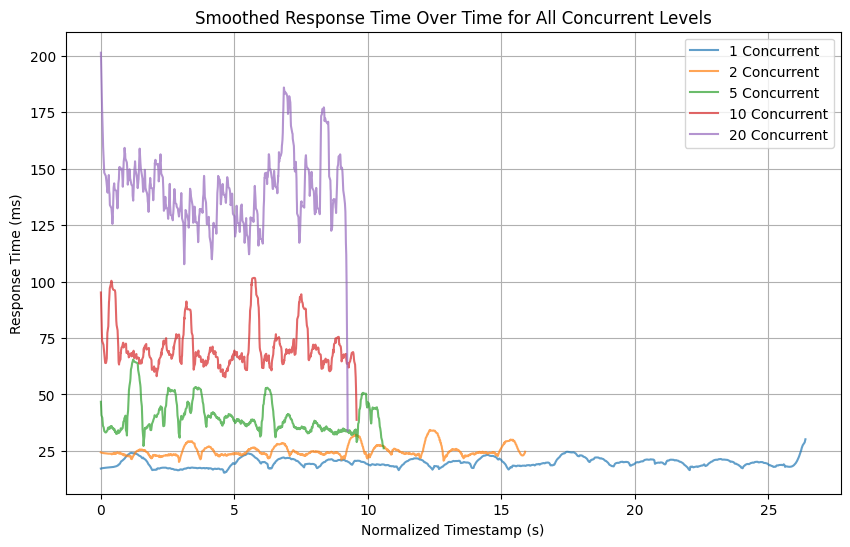

In [73]:
# Plot the response time over time for all concurrent levels with normalized timestamps
plt.figure(figsize=(10, 6))

# Normalize timestamps and plot with smoothing
for concurrent_level, df in zip(
    ["1 Concurrent", "2 Concurrent", "5 Concurrent", "10 Concurrent", "20 Concurrent"],
    [
        df_concurrent_1,
        df_concurrent_2,
        df_concurrent_5,
        df_concurrent_10,
        df_concurrent_20,
    ],
):
    # Normalize timestamps
    df["normalized_timestamp"] = df["timestamp"] - df["timestamp"].min()

    # Apply Savitzky-Golay filter for smoothing
    smoothed_response_time = savgol_filter(
        df["response_time_ms"], window_length=51, polyorder=3
    )

    # Plot smoothed response time
    plt.plot(
        df["normalized_timestamp"],
        smoothed_response_time,
        linestyle="-",
        alpha=0.7,
        label=concurrent_level,
    )

plt.title("Smoothed Response Time Over Time for All Concurrent Levels")
plt.xlabel("Normalized Timestamp (s)")
plt.ylabel("Response Time (ms)")
plt.legend()
plt.grid(True)
plt.show()